In [1]:
using PyPlot
using Random
using LaTeXStrings
using LsqFit
using Primes
using HaltonSequences
using Sobol

using SpecialFunctions
using Statistics
using PyCall
using LinearAlgebra
using Printf
@pyimport matplotlib.patches as patch
fs = 10
def_figsize = (6,5)
colors = ["r", "b", "g", "y", "k", "grey"];

# Exercise 1: Importance sampling

## Define functions that we will need

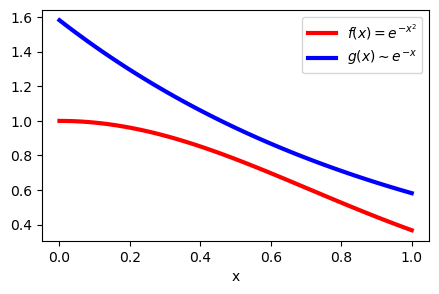

In [2]:
x = LinRange(0,1,50)
function unif(x)
    return 1
end

f(x) = exp(-x^2)
g(x) = exp(-x) * ℯ / (ℯ - 1)


fig, ax = subplots(figsize = (5,3))
ax.plot(x, f.(x), color = colors[1], linewidth = 3)
ax.plot(x, g.(x), color = colors[2], linewidth = 3)
ax.legend([L"f(x) = e^{-x^2}", L"g(x) \sim e^{-x}"], fontsize = fs)
ax.set_xlabel("x", fontsize = fs)
savefig("ex01_funcs.png", bbox_inches = "tight")

## RNGs

In [3]:
function sample_rand()
    return rand()
end

# Buggy... DO NOT USE!
# function sample_halton()
#     return Halton(2, start = round(Int, rand() * 5000))
# end

# Code taken from Ex01.
mutable struct CongruentialRNG
    c::Int
    p::Int
    x_prev::Int
end

function congruential!(gen::CongruentialRNG)
    x_next = (gen.c * gen.x_prev) % gen.p
    gen.x_prev = x_next

    return x_next / gen.p
end;

congruential = CongruentialRNG(3, 31, 5)
function sample_congruential()
    return congruential!(congruential)
end

sample_congruential (generic function with 1 method)

## Sampling method

In [4]:
"""
Generate n_samples samples following the PDF f using rejection sampling and an underlying RNG.

Assumes that the function takes its maximum value at zero.

# Arguments
- `f`: Distribution from which to take the samples.
- `n_samples`: How many samples to take.
- `gen`: Which generator to use.
- `max_tries`: How often to try to place the number.
"""
function rejection_sample(f; n_samples::Int64=2, gen=sample_rand, max_tries=50)
    max = f(0)
    points = zeros(Float64, n_samples)

    for n ∈ 1:n_samples
        for i ∈ 1:max_tries
            x = gen()
            y = max * gen()
            
            # Reject or accept.
            if y <= f(x)
                points[n] = x
                break
            end

            # Log failure.
            if i == max_tries
                println("cannot sample, probability too small after 50 tries")
                points[n] = NaN
            end
        end
    end
    
    return points
end

rejection_sample

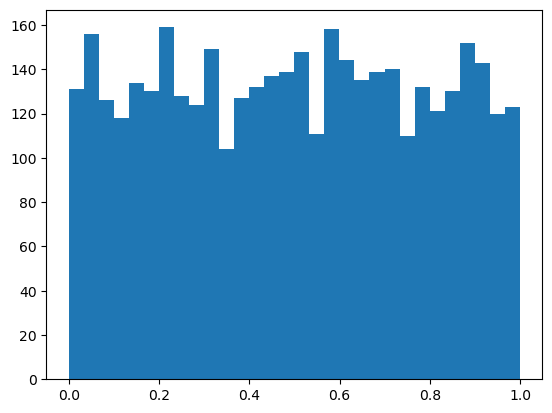

In [5]:
Random.seed!(38527)

p = rejection_sample(unif, n_samples=4000, gen=sample_rand, max_tries=50)
hist(p, bins = 30);

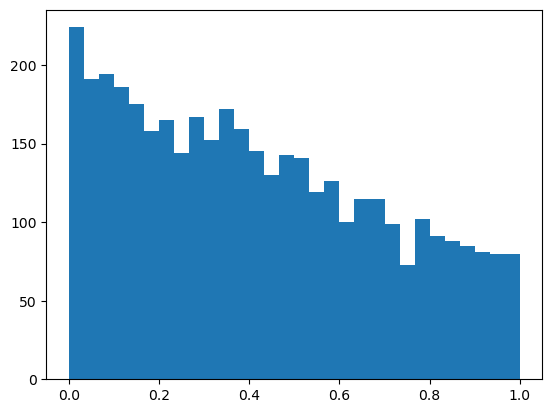

In [6]:
p = rejection_sample(g, n_samples=4000, gen=sample_rand, max_tries=50)
hist(p, bins = 30);

## Midpoint rule integration

In [7]:
function mid_integration(f; N::Int64 = 100)
    x = LinRange(0, 1, N + 1)[2:end] .- 1 / (2N)
    return sum(f.(x)) / N
end

mid_integration (generic function with 1 method)

## Importance sampling

In [8]:
function integration(f, N::Int64=100, g = x -> 1, gen=sample_rand)
    x = rejection_sample(g, n_samples=N, gen=gen)
    return sum(f.(x) ./ g.(x)) / N
end

integration (generic function with 4 methods)

## Convergence

### Get real integral

In [9]:
I_real = mid_integration(f, N = Int64(1e8))

0.746824132812427

### Plot function

In [10]:
# Fit the logarithms to obtain the convergence rate.
@. lin(x, p) = p[1] - p[2] * x
@. ln(x, p) = exp(p[1]) * x^(-p[2])

function plot_convergence!(ax, Ns, error_values, initial_values, color, label)
    # Linear fit of the log-log convergence plot.
    fit = curve_fit(lin, log.(Ns), log.(error_values), initial_values)
    params = coef(fit)
    errors = stderror(fit)
    
    ax.plot(Ns, error_values, linestyle="none", marker="o", color=color, label=label)

    ax.loglog(
        Ns,
        ln(Ns, params),
        color=color,
        label="N^-($(round(params[2], digits = 2))±$(round(errors[2], digits = 2)))"
    )
end

plot_convergence! (generic function with 1 method)

### Perform integration

In [11]:
# Approximate the integral using the midpoint rule and MC using uniform sampling.
Ns = [2^i for i = 1:15]
n_repeat = 1

I_mid = zeros(Float64, length(Ns))
std_mid = zeros(Float64, length(Ns))

I_MC_unif = zeros(Float64, length(Ns))
std_MC_unif = zeros(Float64, length(Ns))

I_MC_unif_congr = zeros(Float64, length(Ns))
std_MC_unif_congr = zeros(Float64, length(Ns))

I_MC_g = zeros(Float64, length(Ns))
std_MC_g = zeros(Float64, length(Ns))

for i ∈ 1:length(Ns)
    error_mid = zeros(Float64, length(Ns))
    error_MC_unif = zeros(Float64, length(Ns))
    error_MC_unif_congr = zeros(Float64, length(Ns))
    error_MC_g = zeros(Float64, length(Ns))
    for j ∈ 1:n_repeat
        error_mid[j] = abs(mid_integration(f, N = Ns[i]) - I_real)
        error_MC_unif[j] = abs(integration(f, Ns[i], x->1, sample_rand) - I_real)
        error_MC_unif_congr[j] = abs(integration(f, Ns[i], x->1, sample_congruential) - I_real)
        error_MC_g[j] = abs(integration(f, Ns[i], g, sample_rand) - I_real)
    end
    I_mid[i] = mean(error_mid)
    I_MC_unif[i] = mean(error_MC_unif)
    I_MC_unif_congr[i] = mean(error_MC_unif_congr)
    I_MC_g[i] = mean(error_MC_g)
    std_mid[i] = std(error_mid)
    std_MC_unif[i] = std(error_MC_unif)
    std_MC_unif_congr[i] = std(error_MC_unif_congr)
    std_MC_g[i] = std(error_MC_g)
end

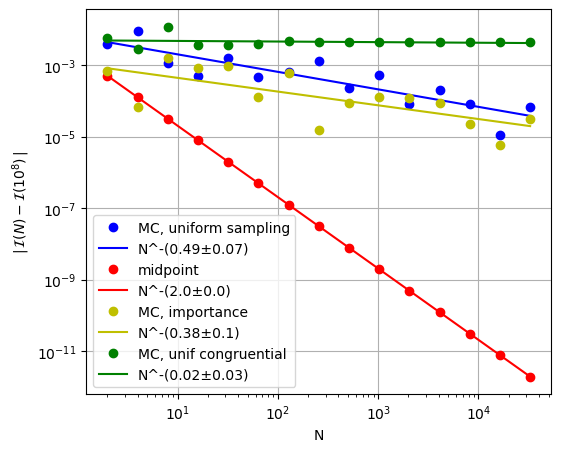

In [12]:
mean_errors = Dict(
    "midpoint" => I_mid,
    "MC_unif" => I_MC_unif,
    "MC_unif_congr" => I_MC_unif_congr,
    "MC_g" => I_MC_g,
)

std_errors = Dict(
    "midpoint" => std_mid,
    "MC_unif" => std_MC_unif,
    "MC_unif_congr" => std_MC_unif_congr,
    "MC_g" => std_MC_g,
)

initial_values = Dict(
    "midpoint" => [1.0, 0.9],
    "MC_unif" => [1.0, 0.9],
    "MC_unif_congr" => [1.0, 0.9],
    "MC_g" => [1.0, 0.9],
)

labels = Dict(
    "midpoint" => "midpoint",
    "MC_unif" => "MC, uniform sampling",
    "MC_unif_congr" => "MC, unif congruential",
    "MC_g" => "MC, importance",
)

plot_colors = Dict(
    "midpoint" => colors[1],
    "MC_unif" => colors[2],
    "MC_unif_congr" => colors[3],
    "MC_g" => colors[4],
)

to_plot = [
    "MC_unif",
    "midpoint",
    "MC_g",
    "MC_unif_congr",
]


fig, ax =  subplots(figsize = def_figsize)
ax.grid()
ax.set_xlabel("N", fontsize = fs)
ax.set_ylabel(L"|\,\mathcal{I}(N) - \mathcal{I}(10^8)\,|", fontsize = fs)
ax.set_xscale("log")
ax.set_yscale("log")

for key ∈ to_plot
    plot_convergence!(
        ax,
        Ns,
        mean_errors[key],
        initial_values[key],
        plot_colors[key],
        labels[key],
    )
end

ax.legend()

savefig("ex01_simple.png", bbox_inches = "tight")

# Hard spheres

## Task 1

In [13]:
function sample_sphere(config, L, R, dim, gen)
    point = zeros(Float64, dim)
    
    n_other_particles = Int64(length(config) / dim)

    # Sample a new position.
    # The box is [0, L]^dim. We do not want to overlap the border,
    # so we place the centers of the spheres in [R, L-R]^dim.
    for d ∈ 1:dim
        point[d] = R + (L - 2*R) * gen()
    end

    # Check for overlaps with existing particles.
    for j ∈ 1:n_other_particles
        r_j = config[(j-1)*dim+1:j*dim]
        d = norm(point .- r_j)

        if d < 2*R
            throw(ErrorException("Overlap detected."))
        end
    end

    return point
end


function sample_config(n_particles, L, R, dim; max_tries=10, gen=sample_rand)
    config = zeros(Float64, dim*n_particles)

    for i ∈ 1:n_particles
        attempt = 1
        while attempt <= max_tries
            try
                config[(i-1)*dim+1:i*dim] = sample_sphere(config[1:(i-1)*dim], L, R, dim, gen)
                break
            catch e
                attempt += 1
            end
        end

        if attempt > max_tries
            throw(ErrorException("Could not sample a new configuration."))
        end
    end

    return config
end

sample_config (generic function with 1 method)

In [14]:
sample_config(2, 10, 0.0001, 3, max_tries=100, gen=sample_rand);

In [15]:
function calculate_d_mean(config, dim)
    n_particles = Int64(length(config) / dim)
    
    d_mean = 0
    
    for i ∈ 1:n_particles
        r_i = config[(i-1)*dim+1:i*dim]
        for j ∈ 1:i-1
            r_j = config[(j-1)*dim+1:j*dim]
            d_mean += norm(r_i .- r_j)
        end
    end
    
    return d_mean * 2 / (n_particles * (n_particles-1))
end

calculate_d_mean (generic function with 1 method)

In [16]:
function run_experiment(M, n_particles, L, R; dim=3, max_tries=10, gen=sample_rand)
    d = zeros(Float64, M)
    for k ∈ 1:M
        config = sample_config(n_particles, L, R, dim, max_tries=max_tries, gen=gen)
        d[k] = calculate_d_mean(config, dim)
    end
    
    return mean(d)
end

run_experiment (generic function with 1 method)

## Task 2 & 3

2
4
8
16


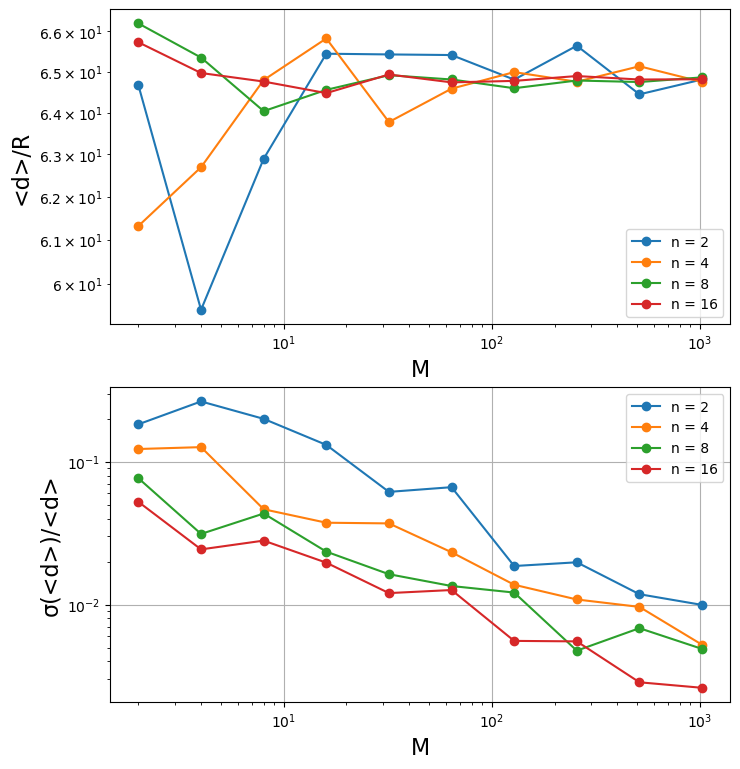

In [17]:
L = 1
R = 0.01
dim = 3
K = 10

M_values = [2^i for i ∈ 1:10]
n_values = [2, 4, 8, 16]


fig, axes = plt.subplots(2, 1, figsize=(8, 9))

for n ∈ n_values
    integral_mean = zeros(Float64, length(M_values))
    integral_std = zeros(Float64, length(M_values))
    println(n)
    ν = n * 4 / 3 * π * R^3 / L^3
    for i ∈ 1:length(M_values)
        integrals = zeros(Float64, K)
        for k ∈ 1:K
            integrals[k] = run_experiment(M_values[i], n, L, R, dim=dim, max_tries=10, gen=sample_rand)
        end
        integral_mean[i] = mean(integrals)
        integral_std[i] = std(integrals)
    end
    
    axes[1].plot(M_values, integral_mean/R, marker="o", label="n = $(n)")
    axes[1].set_ylabel("<d>/R", fontsize=16)
    axes[2].plot(M_values, integral_std./integral_mean, marker="o", label="n = $(n)")
    axes[2].set_ylabel("σ(<d>)/<d>", fontsize=16)
end

for ax ∈ axes
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xlabel("M", fontsize=16)
    ax.grid(true)
    ax.legend()
end

fig.savefig("ex02.png")